# Cross sell predictive modeling for Halfway There 

I will build a model to predict which customer will subscribe to the Half Way There wine service. The goal is to develop a detailed understanding of the features and their relationship with the response variable. 


The first step would be to analyze the dataset for dirty data. 

Then I remove features that are irrelevant to cross selling and engineer a slew of new features based on the ones that remain. 

At this point we are ready to build classification models, perform hyper-parameter tuning to optimize the results, which we will then evaluate the performances and choose the best model.

In [1]:
# importing libraries
import numpy as np                                   # highlevel math functions
import random            as rand                     # random number gen
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
import statsmodels.formula.api as smf                # regression modeling
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler

from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer

from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file name
file = 'Apprentice_Chef_Dataset.xlsx'

# reading file into python
apchef = pd.read_excel(file)

/Users/yVette_1963/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Exploratory data analysis:

   -remove irrelevant features if any
   -missing value detection and imputation
   -feature engineering
   -encoding categorical variables

In [2]:
# checking the first 10 rows of the dataset
# apchef.head(n = 10)

Since no features in the dataset are metrics that occur post cross sell, we 
don't need to remove any features. All of them could be of value to the analysis.

### missing value detection and imputation

In [3]:
############################
### create family groups ###

# print(apchef.isnull().sum())

# 47 family names are missing, however they are active users and we have their 
# contact information. Retain the accounts with missing family names.   

# impute missing values
apchef['FAMILY_NAME'] = apchef['FAMILY_NAME'].fillna('NA')

# check to see result
# print(apchef.isnull().sum().sum())

# check the top largest families
#lst = apchef['FAMILY_NAME'].value_counts()

# placeholder list
placeholder_lst = []

# looping to family groups
for name in apchef.loc[:, 'FAMILY_NAME']:
    if 'Tully' in name:
        placeholder_lst.append('Tully')
    elif 'Frey' in name:
        placeholder_lst.append('Tully')
    elif 'Arryn' in name:
        placeholder_lst.append('Tully')
    elif 'Targaryen' in name:
        placeholder_lst.append('Targaryen')
    elif 'Lannister' in name:
        placeholder_lst.append('Lannister')
    elif 'Baratheon' in name:
        placeholder_lst.append('Baratheon')
    elif 'Tyrell' in name:
        placeholder_lst.append('Tyrell')
    elif 'Stark' in name:
        placeholder_lst.append('Stark')
    elif 'Snow' in name:
        placeholder_lst.append('Stark') 
    elif 'Greyjoy' in name:
        placeholder_lst.append('Greyjoy') 
    elif 'Martell' in name:
        placeholder_lst.append('Martell')
    elif 'Sand' in name:
        placeholder_lst.append('Martell')
    else: 
        placeholder_lst.append('Other')

# converting list into a series
apchef['FAMILY_GROUP'] = pd.Series(placeholder_lst)

# checking results
# apchef.loc[:,'FAMILY_GROUP'].value_counts()

## Feature engineering

Perhaps certain GOT families have similar tastes that make them more prone to 
adopting the wine service. We grouping families by lineage (complicated!)

We continue to group email domains, hoping to find some commonalities among 
people from the same company. 

In [4]:
#########################
# split personal emails #

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in apchef.iterrows():
    
    # splitting email domain at '@'
    split_email = apchef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    
# converte placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

# displaying the results
# email_df

#######################################
# concatenate with original DataFrame #

# renaming column to concatenate
email_df.columns = ['name' , 'EMAIL_DOMAIN']

# concatenating personal_email_domain with friends DataFrame
apchef = pd.concat([apchef, email_df.loc[:, 'EMAIL_DOMAIN']],
                    axis = 1)  # 0 for row, 1 for col

# printing value counts of personal_email_domain
apchef.loc[: ,'EMAIL_DOMAIN'].value_counts()

##################################################
# aggregate domains into higher-level categories #

# email domain types
personal_email_domains = ['gmail.com', 'protonmail.com', 'yahoo.com',
                          'msn.com','aol.com', 'passport.com',
                          'hotmail.com', 'live.com', 'me.com']
corporate_email_domains  = ['amex.com', 'cocacola.com', 'merck.com',
                          'mcdonalds.com', 'jnj.com', 'nike.com', 'apple.com', 
                          'dupont.com', 'ge.org', 'ibm.com', 'chevron.com', 
                          'microsoft.com', 'unitedhealth.com','exxon.com', 
                          'travelers.com','boeing.com', 'caterpillar.com', 
                          'pg.com','verizon.com', 'mmm.com', 'disney.com', 
                          'walmart.com', 'pfizer.com', 'visa.com', 
                          'jpmorgan.com', 'goldmansacs.com', 'cisco.com',
                          'unitedtech.com', 'intel.com', 'homedepot.com']

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in apchef['EMAIL_DOMAIN']:
        if domain in personal_email_domains:
            placeholder_lst.append('personal')
            
        elif domain in corporate_email_domains:
            placeholder_lst.append('corporate')
            
        else:
            print('Unknown')

# concatenating with original DataFrame
apchef['DOMAIN_GROUP'] = pd.Series(placeholder_lst)

# checking results
# apchef['DOMAIN_GROUP'].value_counts()

### Outlier analysis

In the section below, I identify outliers through visualization and develop 
features that reflect the outlier thresholds.
The histograms plotting has been commented out to speed up processing. 

In [5]:
### Visual EDA (Histograms) ###

# fig, ax = plt.subplots(figsize = (10,8))
# plt.subplot(2,2,1)
# sns.distplot(apchef['REVENUE'],
#            bins = 'fd',
#            color = 'g')
# plt.xlabel('REVENUE')

##############################
 
# plt.subplot(2,2,2)
# sns.distplot(apchef['CROSS_SELL_SUCCESS'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'y')
# plt.xlabel('CROSS_SELL_SUCCESS')

##############################
 
# plt.subplot(2,2,3)
# sns.distplot(apchef['TOTAL_MEALS_ORDERED'],
#            bins = 'fd',
#            color = 'orange')
# plt.xlabel('TOTAL_MEALS_ORDERED')

##############################
 
# plt.subplot(2,2,4)
# sns.distplot(apchef['UNIQUE_MEALS_PURCH'],
#            bins = 'fd',
#            color = 'r')
# plt.xlabel('UNIQUE_MEALS_PURCH')
# plt.tight_layout()
# plt.savefig('Ap Chef Data Histograms 1 of 7.png')
# plt.show()

##############################
##############################

# fig, ax = plt.subplots(figsize = (10,8))
# plt.subplot(2,2,1)
# sns.distplot(apchef['CONTACTS_W_CUSTOMER_SERVICE'],
#             bins = 'fd',
#            color = 'g')
# plt.xlabel('CONTACTS_W_CUSTOMER_SERVICE')

##############################
 
# plt.subplot(2,2,2)
# sns.distplot(apchef['PRODUCT_CATEGORIES_VIEWED'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'y')
#plt.xlabel('PRODUCT_CATEGORIES_VIEWED')

##############################
 
#plt.subplot(2,2,3)
#sns.distplot(apchef['AVG_TIME_PER_SITE_VISIT'],
#            bins = 'fd',
#            color = 'orange')
#plt.xlabel('AVG_TIME_PER_SITE_VISIT')

##############################
 
#plt.subplot(2,2,4)
#sns.distplot(apchef['MOBILE_NUMBER'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'r')
#plt.xlabel('MOBILE_NUMBER')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 2 of 7.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.distplot(apchef['CANCELLATIONS_BEFORE_NOON'],
#            bins = 'fd',
#           color = 'g')
#plt.xlabel('CANCELLATIONS_BEFORE_NOON')

##############################
 
#plt.subplot(2,2,2)
#sns.distplot(apchef['CANCELLATIONS_AFTER_NOON'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'y')
#plt.xlabel('CANCELLATIONS_AFTER_NOON')

##############################
 
#plt.subplot(2,2,3)
#sns.distplot(apchef['TASTES_AND_PREFERENCES'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'orange')
#plt.xlabel('TASTES_AND_PREFERENCES')

##############################
 
#plt.subplot(2,2,4)
#sns.distplot(apchef['MOBILE_LOGINS'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'r')
#plt.xlabel('MOBILE_LOGINS')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 3 of 7.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.distplot(apchef['PC_LOGINS'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'g')
#plt.xlabel('PC_LOGINS')

##############################
 
#plt.subplot(2,2,2)
#sns.distplot(apchef['WEEKLY_PLAN'],
 #           bins = 'fd',
 #           color = 'y')
#plt.xlabel('WEEKLY_PLAN')

##############################
 
#plt.subplot(2,2,3)
#sns.distplot(apchef['EARLY_DELIVERIES'],
 #           bins = 'fd',
 #           color = 'orange')
#plt.xlabel('EARLY_DELIVERIES')

##############################
 
#plt.subplot(2,2,4)
#sns.distplot(apchef['LATE_DELIVERIES'],
 #           bins = 'fd',
 #           color = 'r')
#plt.xlabel('LATE_DELIVERIES')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 4 of 7.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.distplot(apchef['PACKAGE_LOCKER'],
#            bins = 'fd',
#            kde = False,
#            rug = True,
#            color = 'g')
#plt.xlabel('PACKAGE_LOCKER')

##############################
 
#plt.subplot(2,2,2)
#sns.distplot(apchef['REFRIGERATED_LOCKER'],
 #           bins = 'fd',
 #           kde = False,
 #           rug = True,
 #           color = 'y')
#plt.xlabel('REFRIGERATED_LOCKER')

##############################
 
#plt.subplot(2,2,3)
#sns.distplot(apchef['FOLLOWED_RECOMMENDATIONS_PCT'],
 #           bins = 'fd',
 #           kde = False,
 #           rug = True,
 #           color = 'orange')
#plt.xlabel('FOLLOWED_RECOMMENDATIONS_PCT')

##############################
 
#plt.subplot(2,2,4)
#sns.distplot(apchef['AVG_PREP_VID_TIME'],
 #           bins = 'fd',
 #           color = 'r')
#plt.xlabel('AVG_PREP_VID_TIME')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 5 of 7.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.distplot(apchef['LARGEST_ORDER_SIZE'],
 #           bins = 'fd',
 #           color = 'g')
#plt.xlabel('LARGEST_ORDER_SIZE')

##############################

#plt.subplot(2,2,2)
#sns.distplot(apchef['MASTER_CLASSES_ATTENDED'],
 #           bins = 'fd',
 #           color = 'y')
#plt.xlabel('MASTER_CLASSES_ATTENDED')

##############################
 
#plt.subplot(2,2,3)
#sns.distplot(apchef['MEDIAN_MEAL_RATING'],
 #           bins = 'fd',
 #           color = 'orange')
#plt.xlabel('MEDIAN_MEAL_RATING')

##############################

#plt.subplot(2,2,4)
#sns.distplot(apchef['AVG_CLICKS_PER_VISIT'],
 #           bins = 'fd',
 #           color = 'r')
#plt.xlabel('AVG_CLICKS_PER_VISIT')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 6 of 7.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.distplot(apchef['TOTAL_PHOTOS_VIEWED'],
 #           bins = 'fd',
 #           kde = False,
 #           rug = True,
 #           color = 'orange')
#plt.xlabel('TOTAL_PHOTOS_VIEWED')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Histograms 7 of 7.png')
#plt.show()

# setting outlier thresholds
REVENUE_hi      = 2400
TOTAL_MEALS_ORDERED_lo = 15
TOTAL_MEALS_ORDERED_hi  = 120
CONTACTS_W_CUSTOMER_SERVICE_hi  = 10
AVG_TIME_PER_SITE_VISIT_hi  = 180
WEEKLY_PLAN_lo  = 1
WEEKLY_PLAN_hi = 14
CANCELLATIONS_BEFORE_NOON_hi  = 5
EARLY_DELIVERIES_lo = 1
EARLY_DELIVERIES_hi = 5
LATE_DELIVERIES_lo = 10
AVG_PREP_VID_TIME_lo    = 60
AVG_PREP_VID_TIME_hi    = 190
LARGEST_ORDER_SIZE_lo     = 1
LARGEST_ORDER_SIZE_hi     = 9
MASTER_CLASSES_ATTENDED_hi     = 1
MEDIAN_MEAL_RATING_lo = 2
MEDIAN_MEAL_RATING_hi  = 4
AVG_CLICKS_PER_VISIT_lo  = 7.5
AVG_CLICKS_PER_VISIT_hi  = 20
TOTAL_PHOTOS_VIEWED_lo = 1

##############################################################################
## Feature Engineering (outlier thresholds)                                 ##
##############################################################################

# developing features (columns) for outliers

# Revenue
apchef['out_REVENUE'] = 0
condition_hi = apchef.loc[0:,'out_REVENUE'][apchef['REVENUE'] > REVENUE_hi]

apchef['out_REVENUE'].replace(to_replace = condition_hi,
                            value      = 1,
                            inplace    = True)

# Total meals ordered
apchef['out_TOTAL_MEALS_ORDERED'] = 0
condition_lo = apchef.loc[0:,'out_TOTAL_MEALS_ORDERED'][apchef['TOTAL_MEALS_ORDERED'] < TOTAL_MEALS_ORDERED_lo]
condition_hi = apchef.loc[0:,'out_TOTAL_MEALS_ORDERED'][apchef['TOTAL_MEALS_ORDERED'] > TOTAL_MEALS_ORDERED_hi]

apchef['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_hi,
                                        value      = 1,
                                        inplace    = True)

# Contacts with customer service
apchef['out_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition_hi = apchef.loc[0:,'out_CONTACTS_W_CUSTOMER_SERVICE'][apchef['CONTACTS_W_CUSTOMER_SERVICE'] > CONTACTS_W_CUSTOMER_SERVICE_hi]

apchef['out_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition_hi,
                                                value      = 1,
                                                inplace    = True)

# Average time per site visit
apchef['out_AVG_TIME_PER_SITE_VISIT'] = 0
condition_hi = apchef.loc[0:,'out_AVG_TIME_PER_SITE_VISIT'][apchef['AVG_TIME_PER_SITE_VISIT'] > AVG_TIME_PER_SITE_VISIT_hi]

apchef['out_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition_hi,
                                            value      = 1,
                                            inplace    = True)

# Weekly plan
apchef['out_WEEKLY_PLAN'] = 0
condition_lo = apchef.loc[0:,'out_WEEKLY_PLAN'][apchef['WEEKLY_PLAN'] < WEEKLY_PLAN_lo]
condition_hi = apchef.loc[0:,'out_WEEKLY_PLAN'][apchef['WEEKLY_PLAN'] > WEEKLY_PLAN_hi]

apchef['out_WEEKLY_PLAN'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_WEEKLY_PLAN'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Cancellations before noon
apchef['out_CANCELLATIONS_BEFORE_NOON'] = 0
condition_hi = apchef.loc[0:,'out_CANCELLATIONS_BEFORE_NOON'][apchef['CANCELLATIONS_BEFORE_NOON'] > CANCELLATIONS_BEFORE_NOON_hi]

apchef['out_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition_hi,
                                                value      = 1,
                                                inplace    = True)

# Early deliveries
apchef['out_EARLY_DELIVERIES'] = 0
condition_lo = apchef.loc[0:,'out_EARLY_DELIVERIES'][apchef['EARLY_DELIVERIES'] < EARLY_DELIVERIES_lo]
condition_hi = apchef.loc[0:,'out_EARLY_DELIVERIES'][apchef['EARLY_DELIVERIES'] > EARLY_DELIVERIES_hi]

apchef['out_EARLY_DELIVERIES'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_EARLY_DELIVERIES'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

# Late deliveries
apchef['out_LATE_DELIVERIES'] = 0
condition_lo = apchef.loc[0:,'out_LATE_DELIVERIES'][apchef['LATE_DELIVERIES'] < LATE_DELIVERIES_lo]

apchef['out_LATE_DELIVERIES'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)


# Average prep video time
apchef['out_AVG_PREP_VID_TIME'] = 0
condition_lo = apchef.loc[0:,'out_AVG_PREP_VID_TIME'][apchef['AVG_PREP_VID_TIME'] < AVG_PREP_VID_TIME_lo]
condition_hi = apchef.loc[0:,'out_AVG_PREP_VID_TIME'][apchef['AVG_PREP_VID_TIME'] > AVG_PREP_VID_TIME_hi]

apchef['out_AVG_PREP_VID_TIME'].replace(to_replace = condition_lo,
                                     value      = 1,
                                     inplace    = True)
apchef['out_AVG_PREP_VID_TIME'].replace(to_replace = condition_hi,
                                     value      = 1,
                                     inplace    = True)

# Largest order size
apchef['out_LARGEST_ORDER_SIZE'] = 0
condition_lo = apchef.loc[0:,'out_LARGEST_ORDER_SIZE'][apchef['LARGEST_ORDER_SIZE'] < LARGEST_ORDER_SIZE_lo]
condition_hi = apchef.loc[0:,'out_LARGEST_ORDER_SIZE'][apchef['LARGEST_ORDER_SIZE'] > LARGEST_ORDER_SIZE_hi]

apchef['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_hi,
                                         value      = 1,
                                         inplace    = True)

# Median meal rating
apchef['out_MEDIAN_MEAL_RATING'] = 0
condition_lo = apchef.loc[0:,'out_MEDIAN_MEAL_RATING'][apchef['MEDIAN_MEAL_RATING'] < MEDIAN_MEAL_RATING_lo]
condition_hi = apchef.loc[0:,'out_MEDIAN_MEAL_RATING'][apchef['MEDIAN_MEAL_RATING'] > MEDIAN_MEAL_RATING_hi]

apchef['out_MEDIAN_MEAL_RATING'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_MEDIAN_MEAL_RATING'].replace(to_replace = condition_hi,
                                         value      = 1,
                                         inplace    = True)

# Average clicks per visit
apchef['out_AVG_CLICKS_PER_VISIT'] = 0
condition_lo = apchef.loc[0:,'out_AVG_CLICKS_PER_VISIT'][apchef['AVG_CLICKS_PER_VISIT'] < AVG_CLICKS_PER_VISIT_lo]
condition_hi = apchef.loc[0:,'out_AVG_CLICKS_PER_VISIT'][apchef['AVG_CLICKS_PER_VISIT'] > AVG_CLICKS_PER_VISIT_hi]

apchef['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_lo,
                                         value      = 1,
                                         inplace    = True)
apchef['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_hi,
                                         value      = 1,
                                         inplace    = True)

# Master classes attended
apchef['out_MASTER_CLASSES_ATTENDED'] = 0
condition_hi = apchef.loc[0:,'out_MASTER_CLASSES_ATTENDED'][apchef['MASTER_CLASSES_ATTENDED'] > MASTER_CLASSES_ATTENDED_hi]

apchef['out_MASTER_CLASSES_ATTENDED'].replace(to_replace = condition_hi,
                                             value      = 1,
                                             inplace    = True)

# Total photos viewed
apchef['out_TOTAL_PHOTOS_VIEWED'] = 0
condition_lo = apchef.loc[0:,'out_TOTAL_PHOTOS_VIEWED'][apchef['TOTAL_PHOTOS_VIEWED'] < TOTAL_PHOTOS_VIEWED_lo]

apchef['out_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition_lo,
                                             value      = 1,
                                             inplace    = True)

### Trend analysis

In the section below, I identify where a variable's trend changes in relationship
with the revenue through visualization and build trend based features.
The scatter plots have been commented out to speed up processing. 

In [6]:
### Visual EDA (Scatterplots) ###

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['CROSS_SELL_SUCCESS'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('CROSS_SELL_SUCCESS')

##############################
 
#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['TOTAL_MEALS_ORDERED'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('TOTAL_MEALS_ORDERED')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['UNIQUE_MEALS_PURCH'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('UNIQUE_MEALS_PURCH')

##############################
 
#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['CONTACTS_W_CUSTOMER_SERVICE'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('CONTACTS_W_CUSTOMER_SERVICE')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 1 of 6.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['PRODUCT_CATEGORIES_VIEWED'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('PRODUCT_CATEGORIES_VIEWED')

##############################
 
#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['AVG_TIME_PER_SITE_VISIT'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('AVG_TIME_PER_SITE_VISIT')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['MOBILE_NUMBER'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('MOBILE_NUMBER')

##############################
 
#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['CANCELLATIONS_BEFORE_NOON'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('CANCELLATIONS_BEFORE_NOON')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 2 of 6.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['CANCELLATIONS_AFTER_NOON'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('CANCELLATIONS_AFTER_NOON')

##############################
 
#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['TASTES_AND_PREFERENCES'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('TASTES_AND_PREFERENCES')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['MOBILE_LOGINS'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('MOBILE_LOGINS')

##############################
 
#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['PC_LOGINS'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('PC_LOGINS')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 3 of 6.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['WEEKLY_PLAN'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('WEEKLY_PLAN')

##############################
 
#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['EARLY_DELIVERIES'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('EARLY_DELIVERIES')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['LATE_DELIVERIES'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('LATE_DELIVERIES')

##############################
 
#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['PACKAGE_LOCKER'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('PACKAGE_LOCKER')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 4 of 6.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['REFRIGERATED_LOCKER'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('REFRIGERATED_LOCKER')

##############################
 
#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['FOLLOWED_RECOMMENDATIONS_PCT'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('FOLLOWED_RECOMMENDATIONS_PCT')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['AVG_PREP_VID_TIME'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('AVG_PREP_VID_TIME')

##############################
 
#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['LARGEST_ORDER_SIZE'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('LARGEST_ORDER_SIZE')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 5 of 6.png')
#plt.show()

##############################
##############################

#fig, ax = plt.subplots(figsize = (10,8))
#plt.subplot(2,2,1)
#sns.scatterplot(x = apchef['MASTER_CLASSES_ATTENDED'],
 #               y = apchef['REVENUE'],
 #               color = 'g')
#plt.xlabel('MASTER_CLASSES_ATTENDED')

##############################

#plt.subplot(2,2,2)
#sns.scatterplot(x = apchef['MEDIAN_MEAL_RATING'],
 #               y = apchef['REVENUE'],
 #               color = 'y')
#plt.xlabel('MEDIAN_MEAL_RATING')

##############################
 
#plt.subplot(2,2,3)
#sns.scatterplot(x = apchef['AVG_CLICKS_PER_VISIT'],
 #               y = apchef['REVENUE'],
 #               color = 'orange')
#plt.xlabel('AVG_CLICKS_PER_VISIT')

##############################

#plt.subplot(2,2,4)
#sns.scatterplot(x = apchef['TOTAL_PHOTOS_VIEWED'],
 #               y = apchef['REVENUE'],
 #               color = 'r')
#plt.xlabel('TOTAL_PHOTOS_VIEWED')
#plt.tight_layout()
#plt.savefig('Ap Chef Data Scatterplot 6 of 6.png')
#plt.show()

# setting trend-based thresholds

TOTAL_MEALS_ORDERED_change_hi  = 15 # trend changes above this point
UNIQUE_MEALS_PURCH_change_hi = 9 # data scatters above this point
CONTACTS_W_CUSTOMER_SERVICE_change_hi  = 10 # trend changes above this point
AVG_TIME_PER_SITE_VISIT_change_hi  = 300 # data scatters above this point
CANCELLATIONS_BEFORE_NOON_change_hi  = 5 # data scatters above this point
CANCELLATIONS_AFTER_NOON_change_hi  = 2 # trend changes above this point
MOBILE_LOGINS_change_hi = 6 # trend changes above this point
PC_LOGINS_change_hi = 2 # trend changes above this point
LATE_DELIVERIES_change_hi = 10 # data scatters above this point
AVG_PREP_VID_TIME_change_hi = 300 # data scatters above this point
LARGEST_ORDER_SIZE_change_hi = 8 # trend changes above this point
MASTER_CLASSES_ATTENDED_change_hi  = 2 # trend changes above this point
MEDIAN_MEAL_RATING_change_hi = 4 # trend changes above this point

MOBILE_LOGINS_change_lo = 4 # data scatters below this point
AVG_CLICKS_PER_VISIT_change_lo  = 10 # data scatters below this point
PC_LOGINS_change_lo = 1 # data scatters below this point

TOTAL_PHOTOS_VIEWED_change_at   = 0 # zero inflated

# developing features (columns) for trend based thresholds

########################################
## change above threshold             ##
########################################

# greater than sign
 
# Total meals ordered
apchef['change_TOTAL_MEALS_ORDERED'] = 0
condition = apchef.loc[0:,'change_TOTAL_MEALS_ORDERED'][apchef['TOTAL_MEALS_ORDERED'] > TOTAL_MEALS_ORDERED_change_hi]

apchef['change_TOTAL_MEALS_ORDERED'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)
# Unique meals purchased
apchef['change_UNIQUE_MEALS_PURCH'] = 0
condition = apchef.loc[0:,'change_UNIQUE_MEALS_PURCH'][apchef['UNIQUE_MEALS_PURCH'] > UNIQUE_MEALS_PURCH_change_hi]

apchef['change_UNIQUE_MEALS_PURCH'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)

# Contacts with customer service
apchef['change_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition = apchef.loc[0:,'change_CONTACTS_W_CUSTOMER_SERVICE'][apchef['CONTACTS_W_CUSTOMER_SERVICE'] > CONTACTS_W_CUSTOMER_SERVICE_change_hi]

apchef['change_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition,
                                                    value      = 1,
                                                    inplace    = True)

# Average time per site visit
apchef['change_AVG_TIME_PER_SITE_VISIT'] = 0
condition = apchef.loc[0:,'change_AVG_TIME_PER_SITE_VISIT'][apchef['AVG_TIME_PER_SITE_VISIT'] > AVG_TIME_PER_SITE_VISIT_change_hi]

apchef['change_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition,
                                                value      = 1,
                                                inplace    = True)

# Cancellations before noon
apchef['change_CANCELLATIONS_BEFORE_NOON'] = 0
condition = apchef.loc[0:,'change_CANCELLATIONS_BEFORE_NOON'][apchef['CANCELLATIONS_BEFORE_NOON'] > CANCELLATIONS_BEFORE_NOON_change_hi]

apchef['change_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition,
                                                value      = 1,
                                                inplace    = True)

# Cancellations after noon
apchef['change_CANCELLATIONS_AFTER_NOON'] = 0
condition = apchef.loc[0:,'change_CANCELLATIONS_AFTER_NOON'][apchef['CANCELLATIONS_AFTER_NOON'] > CANCELLATIONS_AFTER_NOON_change_hi]

apchef['change_CANCELLATIONS_AFTER_NOON'].replace(to_replace = condition,
                                                value      = 1,
                                                inplace    = True)

# Mobile logins
apchef['change_MOBILE_LOGINS'] = 0
condition = apchef.loc[0:,'change_MOBILE_LOGINS'][apchef['MOBILE_LOGINS'] > MOBILE_LOGINS_change_hi]

apchef['change_MOBILE_LOGINS'].replace(to_replace = condition,
                                        value      = 1,
                                        inplace    = True)

# PC logins
apchef['change_PC_LOGINS'] = 0
condition = apchef.loc[0:,'change_PC_LOGINS'][apchef['PC_LOGINS'] > PC_LOGINS_change_hi]

apchef['change_PC_LOGINS'].replace(to_replace = condition,
                                    value      = 1,
                                    inplace    = True)

# Late deliveries
apchef['change_LATE_DELIVERIES'] = 0
condition = apchef.loc[0:,'change_LATE_DELIVERIES'][apchef['LATE_DELIVERIES'] > LATE_DELIVERIES_change_hi]

apchef['change_LATE_DELIVERIES'].replace(to_replace = condition,
                                        value      = 1,
                                        inplace    = True)

# Average prep video time
apchef['change_AVG_PREP_VID_TIME'] = 0
condition = apchef.loc[0:,'change_AVG_PREP_VID_TIME'][apchef['AVG_PREP_VID_TIME'] > AVG_PREP_VID_TIME_change_hi]

apchef['change_AVG_PREP_VID_TIME'].replace(to_replace = condition,
                                        value      = 1,
                                        inplace    = True)

# Largest order size
apchef['change_LARGEST_ORDER_SIZE'] = 0
condition = apchef.loc[0:,'change_LARGEST_ORDER_SIZE'][apchef['LARGEST_ORDER_SIZE'] > LARGEST_ORDER_SIZE_change_hi]

apchef['change_LARGEST_ORDER_SIZE'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)

# Median meal rating
apchef['change_MEDIAN_MEAL_RATING'] = 0
condition = apchef.loc[0:,'change_MEDIAN_MEAL_RATING'][apchef['MEDIAN_MEAL_RATING'] > MEDIAN_MEAL_RATING_change_hi]

apchef['change_MEDIAN_MEAL_RATING'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)

########################################
## change at threshold                ##
########################################

# double-equals sign

# Total photos viewed
apchef['change_TOTAL_PHOTOS_VIEWED'] = 0
condition = apchef.loc[0:,'change_TOTAL_PHOTOS_VIEWED'][apchef['TOTAL_PHOTOS_VIEWED'] == TOTAL_PHOTOS_VIEWED_change_at]

apchef['change_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)

# checking results
# apchef.head(n = 10)

########################################
## change below threshold             ##
########################################

# less than sign

# Mobile logins
condition = apchef.loc[0:,'change_MOBILE_LOGINS'][apchef['MOBILE_LOGINS'] < MOBILE_LOGINS_change_lo]

apchef['change_MOBILE_LOGINS'].replace(to_replace = condition,
                                        value      = 1,
                                        inplace    = True)

# PC logins
condition = apchef.loc[0:,'change_PC_LOGINS'][apchef['PC_LOGINS'] < PC_LOGINS_change_lo]

apchef['change_PC_LOGINS'].replace(to_replace = condition,
                                    value      = 1,
                                    inplace    = True)

# Average clicks per visit
apchef['change_AVG_CLICKS_PER_VISIT'] = 0
condition = apchef.loc[0:,'change_AVG_CLICKS_PER_VISIT'][apchef['AVG_CLICKS_PER_VISIT'] < AVG_CLICKS_PER_VISIT_change_lo]

apchef['change_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition,
                                            value      = 1,
                                            inplace    = True)

### Encoding categorical variables

In the section below, I identify all the categorical variables, conduct analysis
through visualization and build dummy variables to replace object type data.
The dummy variable columns are added to the original dataset where the 
categorical columns are dropped to prevent errors when running models.

The box plots have been commented out to speed up processing. 

In [7]:
# printing columns where the variables for analysis are categorical

# print(f"""
# FAMILY_GROUP
# {apchef['FAMILY_GROUP'].value_counts()}

# EMAIL_DOMAIN
# {apchef['EMAIL_DOMAIN'].value_counts()}

# DOMAIN_GROUP
# {apchef['DOMAIN_GROUP'].value_counts()}
# """)

# defining a function for categorical boxplots
# def categorical_boxplots(response, cat_var, data):
#     """
# 	This function can be used for categorical variables

# 	PARAMETERS
# 	----------
# 	response : str, response variable
# 	cat_var  : str, categorical variable
# 	data     : DataFrame of the response and categorical variables
# 	"""

#    apchef.boxplot(column 	     = response,
#    	           by 	 		 = cat_var,
#        	       vert 	     = False,
#            	   patch_artist = False,
#                   meanline     = True,
#               	   showmeans    = True)

#    plt.suptitle("")
#    plt.savefig(f'Ap Chef Data Boxplot {cat_var}.png')
#    plt.show()

# calling the function for each categorical variable
#categorical_boxplots(response = 'REVENUE',
#					 cat_var  = 'FAMILY_GROUP',
#					 data     = apchef)
#categorical_boxplots(response = 'REVENUE',
#					 cat_var  = 'EMAIL_DOMAIN',
#					 data     = apchef)
#categorical_boxplots(response = 'REVENUE',
#					 cat_var  = 'DOMAIN_GROUP',
#					 data     = apchef)

# one hot encoding categorical variables
one_hot_FAMILY_GROUP       = pd.get_dummies(apchef['FAMILY_GROUP'])
one_hot_EMAIL_DOMAIN       = pd.get_dummies(apchef['EMAIL_DOMAIN'])
one_hot_DOMAIN_GROUP       = pd.get_dummies(apchef['DOMAIN_GROUP'])

# dropping categorical variables after they've been encoded
apchef = apchef.drop('FAMILY_GROUP', axis = 1)
apchef = apchef.drop('EMAIL_DOMAIN', axis = 1)
apchef = apchef.drop('DOMAIN_GROUP', axis = 1)

# joining codings together
apchef = apchef.join([one_hot_FAMILY_GROUP, one_hot_EMAIL_DOMAIN, one_hot_DOMAIN_GROUP])

# saving new columns
new_columns = apchef.columns

## Model building

Now that I have finished developing features, we are ready to start the model 
building. As a first step, let's see how the explanatory variables correlate to 
the response variable.

In [8]:
# dropping categorical variables 
apchef = apchef.drop(labels = ['NAME','EMAIL','FIRST_NAME', 'FAMILY_NAME'], 
                     axis = 1)

# checking the results
# apchef.columns

df_corr = apchef.corr().round(2)

# printing (Pearson) correlations with Revenue
# df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

### Train split test with Stratification

It is important to prevent a response variable that is too imbalanced which can 
cause issues in our modeling. Therefore, I performed stratification in the 
training dataset in the train split test stage.

In [9]:
# declaring explanatory variables
apchef_explanatory = apchef.drop(labels='CROSS_SELL_SUCCESS', 
                            axis=1)

# declaring response variable
apchef_target = apchef.loc[:,'CROSS_SELL_SUCCESS']

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            apchef_explanatory,
            apchef_target,
            test_size = 0.25,
            random_state = 219, 
            stratify = apchef_target)

# merging training data for statsmodels
apchef_train = pd.concat([X_train, y_train], axis = 1)

### Logistic regression in statsmodels

To start with, we build a logistic regression model in statsmodels using all of 
the explanatory variables. Based on the output above, we remove all variables 
that were deemed insignificant based on their p-values. 

Then, we check the p-values again to ensure that all variables are still 
significant (nan are insignificant and the corresponding variables are removed). 

The insignificant p-values are removed in an meticulous and incremental fashion 
due to high collinearity among the variables (i.e. outlier flags and trend based
thresholds derived from the same column). The correlation matrix is also used 
for  choosing which variable to eliminate first when it comes to similar p-values: 
lower correlations are favored to be removed first. 

The summary yields valuable and interpretable insight on the variables that 
affect cross selling success.

For productivity improvement, the following loop is written to print all 
explanatory variables.

In [19]:
# formatting each explanatory variable for statsmodels
# for val in apchef_explanatory:
#     print(f"apchef_train['{val}'] +")

# instantiating a logistic regression model object
logit_fit = smf.logit(formula = """ CROSS_SELL_SUCCESS ~ apchef_train['AVG_TIME_PER_SITE_VISIT'] +
                                    apchef_train['MOBILE_NUMBER'] +
                                    apchef_train['CANCELLATIONS_AFTER_NOON'] +
                                    apchef_train['TASTES_AND_PREFERENCES'] +
                                    apchef_train['PC_LOGINS'] +
                                    apchef_train['REFRIGERATED_LOCKER'] +
                                    apchef_train['FOLLOWED_RECOMMENDATIONS_PCT'] +
                                    apchef_train['change_LATE_DELIVERIES'] +
                                    apchef_train['Greyjoy'] +
                                    apchef_train['jpmorgan.com'] +
                                    apchef_train['microsoft.com'] +
                                    apchef_train['msn.com']""",
                                     data    = apchef_train)

# fitting the model object
logit_fit = logit_fit.fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.465276
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                           12
Date:                Thu, 06 Feb 2020   Pseudo R-squ.:                  0.2591
Time:                        08:39:46   Log-Likelihood:                -678.84
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 5.303e-94
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                               

In [11]:
# updating explanatory variables in scikit-learn 
x_variables = ['AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 
               'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES',
               'PC_LOGINS', 'REFRIGERATED_LOCKER', 
               'FOLLOWED_RECOMMENDATIONS_PCT', 'change_LATE_DELIVERIES',
               'Greyjoy', 'jpmorgan.com', 'microsoft.com', 'msn.com']

# updating variable DataFrame based the the analysis above
apchef_explanatory  = apchef_explanatory.loc[ : , x_variables]

# updating train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            apchef_explanatory,
            apchef_target,
            test_size = 0.25,
            random_state = 219, 
            stratify = apchef_target)

# updating training data 
apchef_train = pd.concat([X_train, y_train], axis = 1)

### Logistic regression in scikit-learn
Build a logistic regression model in scikit-learn using the logit_sig 
explanatory variables and CROSS_SELL_SUCCESS as the  response variable.

In [12]:
# train/test split with the significant variables
X_train, X_test, y_train, y_test = train_test_split(
            apchef_explanatory,
            apchef_target,
            random_state = 802,
            test_size    = 0.25,
            stratify     = apchef_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            max_iter = 1000,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(X_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(X_test)

# creating an empty list
model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]


# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)


# test accuracy
logreg_test_acc   = logreg_fit.score(X_test, y_test).round(4)


# auc value
logreg_auc = roc_auc_score(y_true  = y_test,
                           y_score = logreg_pred).round(4)

# saving the results
model_performance.append(['Logistic Regression',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

### KNN classification model

In this section, I will scale the explanatory data and build a KNN 
classification model.

#### User defined functions

For productivity improvement, the following user defined functions is written 
to search for the optimal neighbors in KNN.

In [13]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=802,
                      response_type='reg',
                      max_neighbors=20):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 802
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
"""    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)

    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)

    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))
    
    # returning optimal number of neighbors
    # print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)
    print(cm)
    

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                 y_data = y_train)

# INSTANTIATING StandardScaler()
scaler = StandardScaler()

# FITTING the data
scaler.fit(apchef_explanatory)

# TRANSFORMING the data
X_scaled     = scaler.transform(apchef_explanatory)

# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            apchef_target,
            random_state = 219,
            test_size = 0.25,
            stratify = apchef_target)

# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)

# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)

# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)

# train accuracy
knn_train_acc = knn_fit.score(X_train_scaled, y_train_scaled).round(4)


# test accuracy
knn_test_acc  = knn_fit.score(X_test_scaled, y_test_scaled).round(4)


# auc value
knn_auc       = roc_auc_score(y_true  = y_test_scaled,
                              y_score = knn_pred).round(4)

# saving the results
model_performance.append(['KNN Classification',
                          knn_train_acc,
                          knn_test_acc,
                          knn_auc])

Note: The optimal number of neighbors is: 20. 

### CART  classification trees 

Instead of building a CART model that grows until it cannot grow further and 
overfits to training data, I am building a pruned tree with a maximum depth of 4 
and a minimum number of samples per leaf of 25. 

The following user defined function is loaded for CART output to extract 
insight. 

/Users/yVette_1963/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


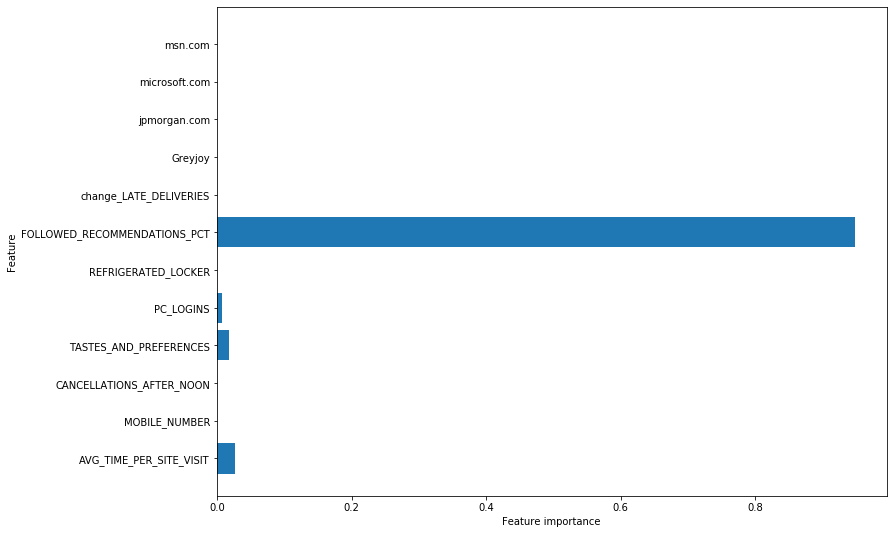

In [14]:
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

def display_tree(tree, feature_df, height = 500, width = 800, export = False):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    export     : bool, defalut False
        whether or not to export the tree as a .png file
    """
    # visualizing the tree
    dot_data = StringIO()
    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)

    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width,
                unconfined = True)

    return img        


# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth = 4,
                    min_samples_leaf=25,
                    random_state=219)

# FITTING the training data
tree_pruned_fit = tree_pruned.fit(X_train, y_train)

# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)

# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

# train accuracy
p_tree_train_acc = tree_pruned_fit.score(X_train, y_train).round(4)


# test accuracy
p_tree_test_acc  = tree_pruned_fit.score(X_test, y_test).round(4)


# auc value
p_tree_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = tree_pred).round(4)

# saving the results
model_performance.append(['Pruned Tree',
                          p_tree_train_acc,
                          p_tree_test_acc,
                          p_tree_auc])

# calling display_tree
# display_tree(tree       = tree_pruned_fit,
#             feature_df = X_train)

### Hyperparameter Tuning with GridSearchCV

In the following section, I will automate this process using GridSearchCV to 
automate hyperparameter optimization on both Logistic Regression and CART model.

#### Tuned Classification Trees

In this section, I will develop a tuned classification tree model using GridSearchCV. 

In [15]:
# INSTANTIATING a logistic regression model with tuned values

tree_tuned = DecisionTreeClassifier(criterion = 'entropy',
                                  max_depth = 4,
                                  min_samples_leaf = 1,
                                  splitter = 'best')

#fit
tree_tuned_fit = tree_tuned.fit(X_train,y_train)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(X_test)

# declaring model performance objects
tree_train_acc = tree_tuned.score(X_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(X_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,y_score = tree_tuned_pred).round(4)

# saving the results
model_performance.append(['Tuned Tree',
                          tree_train_acc, 
                          tree_test_acc, 
                          tree_auc])

# calling display_tree
# display_tree(tree       = tree_tuned_fit,
#              feature_df = X_train)

### Random forest

In this section, I will build a random forest model using the significant set of explanatory variables ( logit_sig ) and default values for the hyperparameters. 

/Users/yVette_1963/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


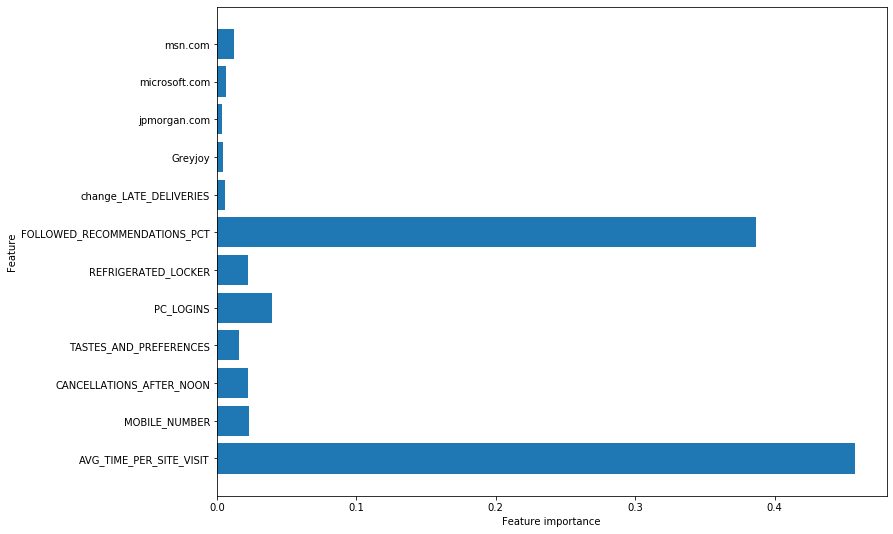

In [16]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 10,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)

plot_feature_importances(rf_default_fit,
                         train = X_train,
                         export = False)

# declaring model performance objects
rf_train_acc = rf_default_fit.score(X_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(X_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)

# appending to model_performance
model_performance.append(['Random Forest',rf_train_acc, rf_test_acc, rf_auc])

### Gradient boosted machines

In this section, I develop a GradientBoostingClassifier model with default 
values for the hyperparameters. 

In [17]:
# INSTANTIATING the model object without hyperparameters
gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 802)

# FIT step is needed as we are not using .best_estimator
gbm_default_fit = gbm_default.fit(X_train, y_train)

# PREDICTING based on the testing set
gbm_default_pred = gbm_default_fit.predict(X_test)

# declaring model performance objects
gbm_train_acc = gbm_default_fit.score(X_train, y_train).round(4)
gbm_test_acc  = gbm_default_fit.score(X_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = gbm_default_pred).round(4)

# appending to model_performance
model_performance.append(['GBM', gbm_train_acc, gbm_test_acc, gbm_auc])

# checking the results
model_performance

[['Model', 'Training Accuracy', 'Testing Accuracy', 'AUC Value'],
 ['Logistic Regression', 0.7019, 0.7248, 0.6637],
 ['KNN Classification', 0.7608, 0.7105, 0.6819],
 ['Pruned Tree', 0.7622, 0.7413, 0.7266],
 ['Tuned Tree', 0.767, 0.7433, 0.7298],
 ['Random Forest', 0.9829, 0.7166, 0.6899],
 ['GBM', 0.841, 0.7556, 0.7338]]

## Evaluate models

Now it's time to evaluate the performances and choose the best model by comparing
AUC.

In [18]:
# converting to DataFrame and checking the results
model_performance_df = pd.DataFrame(model_performance[1:], columns = model_performance[0])

model_performance_df.sort_values(by = 'AUC Value', ascending = False)

,Model,Training Accuracy,Testing Accuracy,AUC Value
5,GBM,0.8410,0.7556,0.7338
3,Tuned Tree,0.7670,0.7433,0.7298
2,Pruned Tree,0.7622,0.7413,0.7266
4,Random Forest,0.9829,0.7166,0.6899
1,KNN Classification,0.7608,0.7105,0.6819
0,Logistic Regression,0.7019,0.7248,0.6637


According to AUC, GBM gives us the best prediction accuracy, even though it is 
overfitted (the difference between training and testing score is far beyond 
0.05). 

However, this result tells us that the gradient boosted machines model 
has 73.4% chance of telling whether a customer in the database is going to buy
Halfway There. 


AUC primarily takes into account Sensitivity, which is how many times the model 
predicts that an existing customer will buy the new product over how many times 
they actually will buy the new product. On the other hand, the model also predicts 
the Specificity, which is how many times the it predicts that a customer won't 
adopt the new product over how many times she actually does not adopt the new product.